### **1. Import all neccessery libraries**

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.oauth2 import service_account
from scipy import stats
import warnings

### **2. Data Collection and DataFrame Inspection**

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "vehicle-sales-data-453815-942c0f4e44da.json"
credentials = service_account.Credentials.from_service_account_file('vehicle-sales-data-453815-942c0f4e44da.json')


In [7]:
client = bigquery.Client()

In [8]:
def query_bigquery_to_df(query: str) -> pd.DataFrame:
    """
    Executes a SQL query on Google BigQuery and returns the result as a pandas DataFrame.

    :param query: SQL query to be executed on BigQuery.
    :return: The query result as a pandas DataFrame.
    """
    client = bigquery.Client()

    query_job = client.query(query)

    df = query_job.result().to_dataframe()

    return df

**Checking the presence of missing values ​​in all columns**

In [10]:
with open("check_missing_values.sql", "r") as file:
    query = file.read()

In [11]:
df_missing = query_bigquery_to_df(query)
df_missing.T

,0
year_missing,0
make_missing,10301
model_missing,10399
trim_missing,10651
body_missing,13195
transmission_missing,65352
vin_missing,4
state_missing,0
condition_missing,11820
odometer_missing,94


Observations:

As we can see, the original table contains rows with missing values in some columns. The 'transmission' column has the highest number of missing values.  Considering the small size of the original data and the need to preserve it, we will create a copy of the table and either fill in the missing values (if necessary) or remove the corresponding rows from the dataset. In other cases, we would have modified the original data directly.

The query for creating a new table is provided in the file "create_car_prices_cleaned.sql". Additionally, when creating the new table from the original dataset: 
- we excluded records with an incorrect "saledate" format and records with "sellingprice" <= 1;
- the values in the columns "make", "model", "trim", "body" and "transmission" were converted to uppercase (see the query).

Let's check missing values in new table.

In [14]:
with open("check_missing_values_cleaned_table.sql", "r") as file:
    query = file.read()
    
df_missing = query_bigquery_to_df(query)
df_missing.T

,0
year_missing,0
make_missing,0
model_missing,0
trim_missing,0
body_missing,0
transmission_missing,0
vin_missing,0
state_missing,0
condition_missing,0
odometer_missing,0


Let's check the dataset for duplicates:

In [16]:
with open("сheck_for_duplicates.sql", "r") as file:
    query = file.read()
    
query_bigquery_to_df(query)

,vin,make,model,trim,body,transmission,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,duplicates


Let's check negative odometer value:

In [18]:
with open("check_negative_odometer.sql", "r") as file:
    query = file.read()
    
query_bigquery_to_df(query)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate


Let's check the main characteristics of numerical columns:

In [20]:
with open("сheck_main_characteristics.sql", "r") as file:
    query = file.read()
    
query_bigquery_to_df(query)

,Min_Year,Max_Year,Avg_Year,Min_Condition,Max_Condition,Avg_Condition,Min_Odometer,Max_Odometer,Avg_Odometer,Min_MMR,Max_MMR,Avg_MMR,Min_SellingPrice,Max_SellingPrice,Avg_SellingPrice
0,1982,2015,2010.036894,1.0,49.0,30.673145,1.0,999999.0,68344.191426,25.0,182000.0,13764.583579,100,230000,13607.21299


To proceed with further analysis, let's load the cleaned table into the dataset, conduct an analysis and transform the data types of some columns.

In [22]:
with open("load_table_to_df.sql", "r") as file:
    query = file.read()
    
df = query_bigquery_to_df(query)

In [23]:
df['saledate'] = pd.to_datetime(df['saledate'], dayfirst=True)

In [24]:
print(df['saledate'].isna().sum())

0


In [25]:
df['year'] = pd.to_datetime(df['year'], format='%Y').dt.year

In [26]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,1997,ACURA,CL,2.2 PREMIUM,COUPE,MANUAL,19uya1150vl018229,ca,2.0,375363.0,red,black,onemain rem/alliance motor cars,475.0,400,2015-01-14
1,1997,ACURA,CL,2.2 PREMIUM,COUPE,MANUAL,19uya1152vl011623,md,2.0,234679.0,green,gray,purple heart services inc,700.0,350,2015-01-20
2,1997,ACURA,CL,2.2 PREMIUM,COUPE,MANUAL,19uya1159vl021033,fl,19.0,271135.0,black,black,autonation toyota pinellas park,775.0,600,2015-02-24
3,1997,ACURA,CL,2.2,COUPE,AUTOMATIC,19uya1247vl006813,va,2.0,123999.0,green,gray,purple heart,1175.0,325,2014-12-18
4,1997,ACURA,CL,2.2,COUPE,AUTOMATIC,19uya1249vl015397,nc,19.0,175551.0,blue,gray,dt credit corporation,875.0,1400,2015-02-03


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558594 entries, 0 to 558593
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          558594 non-null  int32         
 1   make          558594 non-null  object        
 2   model         558594 non-null  object        
 3   trim          558594 non-null  object        
 4   body          558594 non-null  object        
 5   transmission  558594 non-null  object        
 6   vin           558594 non-null  object        
 7   state         558594 non-null  object        
 8   condition     558594 non-null  float64       
 9   odometer      558594 non-null  float64       
 10  color         558594 non-null  object        
 11  interior      558594 non-null  object        
 12  seller        558594 non-null  object        
 13  mmr           558594 non-null  float64       
 14  sellingprice  558594 non-null  Int64         
 15  saledate      558

In [28]:
df.shape

(558594, 16)

In [29]:
df.describe().round(2)

,year,condition,odometer,mmr,sellingprice,saledate
count,558594.00,558594.00,558594.00,558594.00,558594.0,558594
mean,2010.04,30.67,68344.19,13764.58,13607.21,2015-03-06 04:16:57.445945344
min,1982.00,1.00,1.00,25.00,100.0,2014-01-01 00:00:00
25%,2007.00,24.00,28397.25,7100.00,6900.0,2015-01-21 00:00:00
50%,2012.00,34.00,52294.00,12250.00,12100.0,2015-02-13 00:00:00
75%,2013.00,41.00,99123.00,18300.00,18200.0,2015-05-22 00:00:00
max,2015.00,49.00,999999.00,182000.00,230000.0,2015-07-21 00:00:00
std,3.97,13.26,53391.66,9675.31,9745.31,NaN


In [30]:
df.describe(exclude=[float, int, 'datetime']).T

,count,unique,top,freq
make,558594,66,FORD,104287
model,558594,851,ALTIMA,29737
trim,558594,1887,BASE,66490
body,558594,45,SEDAN,254458
transmission,558594,2,AUTOMATIC,541051
vin,558594,550087,wbanv13588cz57827,5
state,558594,38,fl,82919
color,558594,20,black,111680
interior,558594,17,black,244959
seller,558594,14258,nissan-infiniti lt,19692


In [31]:
df.duplicated().sum()

0

In [32]:
df.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

In [33]:
df['transmission'] = df['transmission'].astype('category')
df['color'] = df['color'].astype('category')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558594 entries, 0 to 558593
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          558594 non-null  int32         
 1   make          558594 non-null  object        
 2   model         558594 non-null  object        
 3   trim          558594 non-null  object        
 4   body          558594 non-null  object        
 5   transmission  558594 non-null  category      
 6   vin           558594 non-null  object        
 7   state         558594 non-null  object        
 8   condition     558594 non-null  float64       
 9   odometer      558594 non-null  float64       
 10  color         558594 non-null  category      
 11  interior      558594 non-null  object        
 12  seller        558594 non-null  object        
 13  mmr           558594 non-null  float64       
 14  sellingprice  558594 non-null  Int64         
 15  saledate      558

### **3. Defining Analytical Questions**

#### **3.1 Is there any relationship between manufacturing year of the vehicle and its price, as well as between the odometer values and the price?**

To answer this question, let's plot relevant graphs:

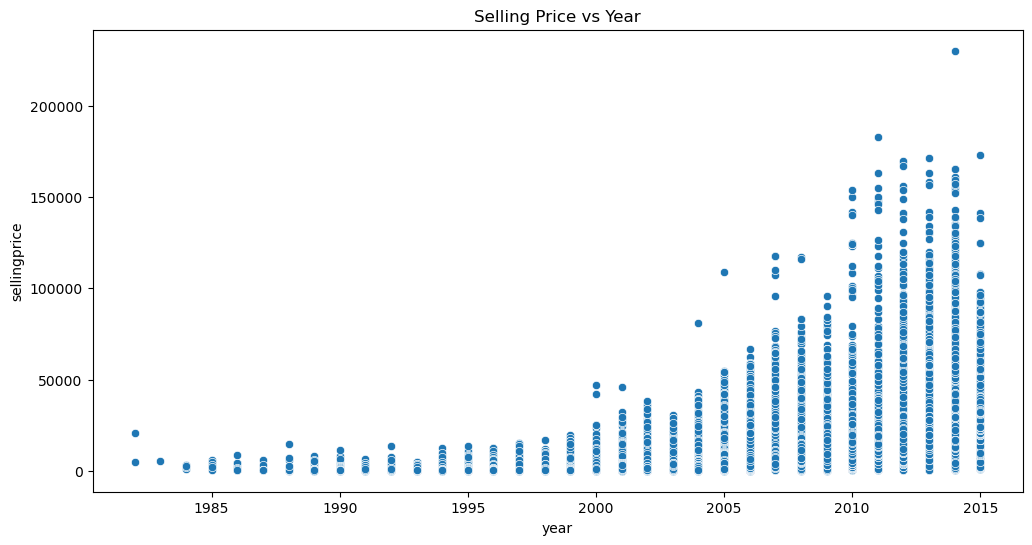

In [38]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='year', y='sellingprice', data=df)
plt.title('Selling Price vs Year')
plt.show()

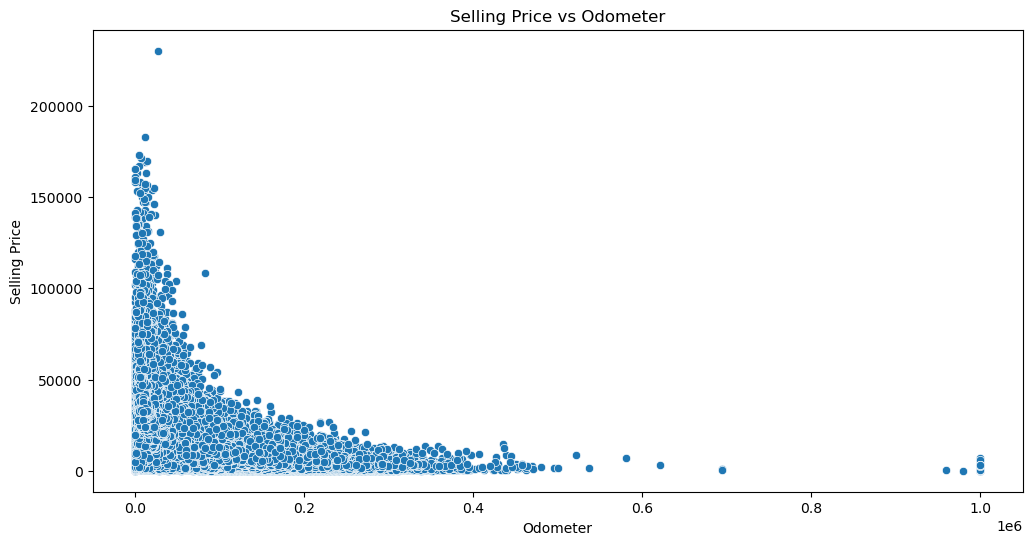

In [39]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='odometer', y='sellingprice', data=df)
plt.title('Selling Price vs Odometer')
plt.xlabel('Odometer')
plt.ylabel('Selling Price')
plt.show()

As we can see from the graphs, there is a direct relationship between manufacturing year of the vehicle and its price, as well as between the selling price and the odometer values. In general, the older the car or the higher the odometer values, the lower its price will be.

#### **3.2 Which car make has the highest average price? Calculate and plot the graph?**

In [42]:
avg_price_by_make = df.groupby('make')['sellingprice'].agg(['mean']).round(2)

print(avg_price_by_make.sort_values(by='mean', ascending=False)) 

                  mean
make                  
ROLLS-ROYCE  153488.24
FERRARI      127210.53
LAMBORGHINI   112625.0
BENTLEY       74367.67
AIRSTREAM      71000.0
...                ...
DODGE TK         550.0
GEO             528.95
DOT              500.0
FORD TRUCK      483.33
DAEWOO           400.0

[66 rows x 1 columns]


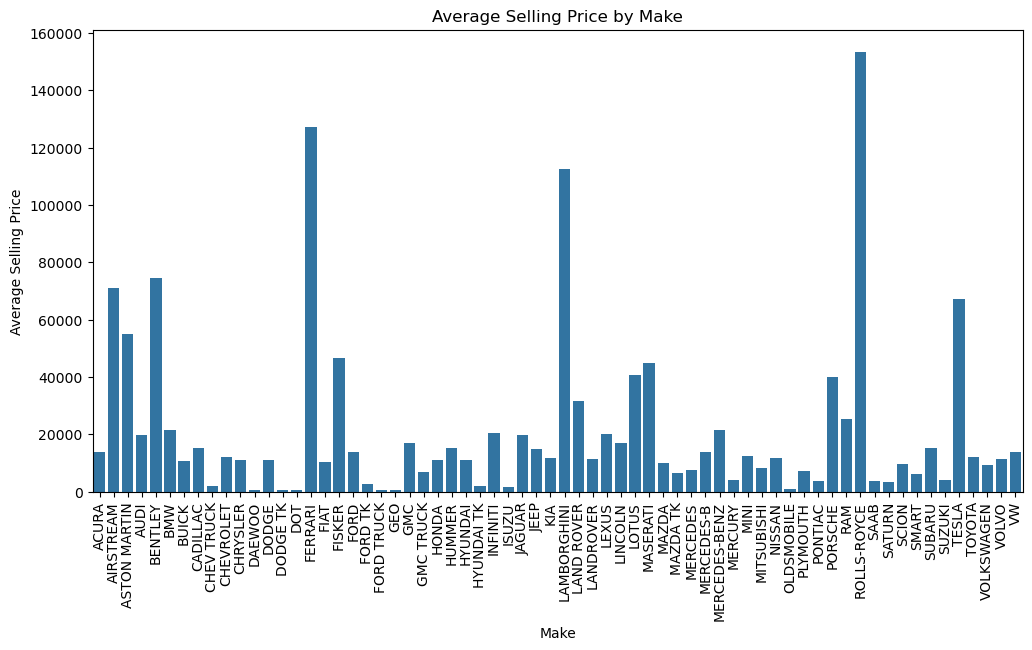

In [43]:
plt.figure(figsize=(12, 6))
sns.barplot(x='make', y='mean', data=avg_price_by_make)
plt.title('Average Selling Price by Make')
plt.xlabel('Make')
plt.ylabel('Average Selling Price')
plt.xticks(rotation=90)
plt.show()

As we can see, ROLLS-ROYCE has the highest average price.

#### **3.3 What is the relationship between the type of transmission and car selling price, and how often do cars with automatic or manual transmissions appear in different price ranges?**

Let's create a pivot table of average selling price and Manheim Market Report (MMR)  by transmission type:

In [47]:
pivot_table = df.pivot_table(
    values=['sellingprice', 'mmr'], 
    index=['transmission'],
    aggfunc={'sellingprice': 'mean', 'mmr': 'mean', 'transmission': 'count'}
)

pivot_table.columns = ['Average Selling Price', 'Average MMR Price', 'Count of Cars']

pivot_table = pivot_table.round({'Average Selling Price': 2, 'Average MMR Price': 2})

print(pivot_table)

              Average Selling Price  Average MMR Price  Count of Cars
transmission                                                         
AUTOMATIC                  13838.07           13684.89         541051
MANUAL                     11498.30           11211.46          17543


Let's plot a histogram of the distribution of car selling prices based on the transmission type.

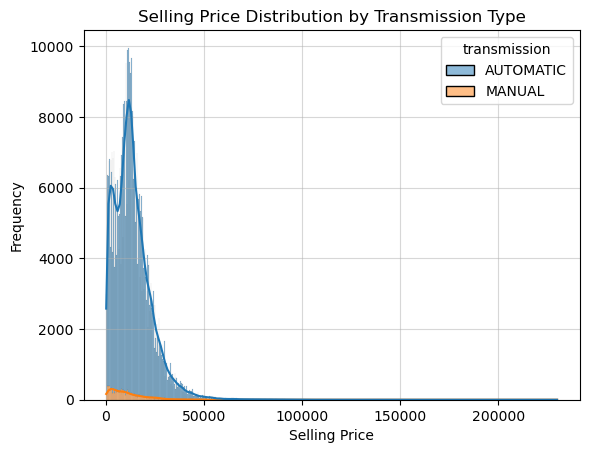

In [49]:
sns.histplot(data=df, x='sellingprice', hue='transmission', kde=True, multiple='stack')
plt.title('Selling Price Distribution by Transmission Type')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.grid(alpha=0.5)
plt.show()

As we can see: 
- cars with automatic transmission are more common in the price ranges up to 15 thousand, while cars with manual transmission are more common up to 5 thousand;
- in higher price ranges, cars with automatic transmission are more common.

Let's perform a t-test to check if there is a statistically significant difference in the average prices of cars with automatic and manual transmissions.

In [52]:
auto_transmission = df[df['transmission'] == 'AUTOMATIC']['sellingprice']
manual_transmission = df[df['transmission'] == 'MANUAL']['sellingprice']

t_stat, p_value = stats.ttest_ind(auto_transmission, manual_transmission)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in prices between automatic and manual transmissions.")
else:
    print("There is no statistically significant difference in prices between automatic and manual transmissions.")

T-statistic: 33.11712820015536
P-value: 2.886937807451677e-240
There is a statistically significant difference in prices between automatic and manual transmissions.


The t-test results indicate a significant difference in the prices of cars with automatic and manual transmissions. In other words, the prices of cars with automatic transmissions are consistently higher than those with manual transmissions.

#### **3.4 How does the estimated market value of the vehicle according to the Manheim Market Report (MMR) compare to its selling price?**

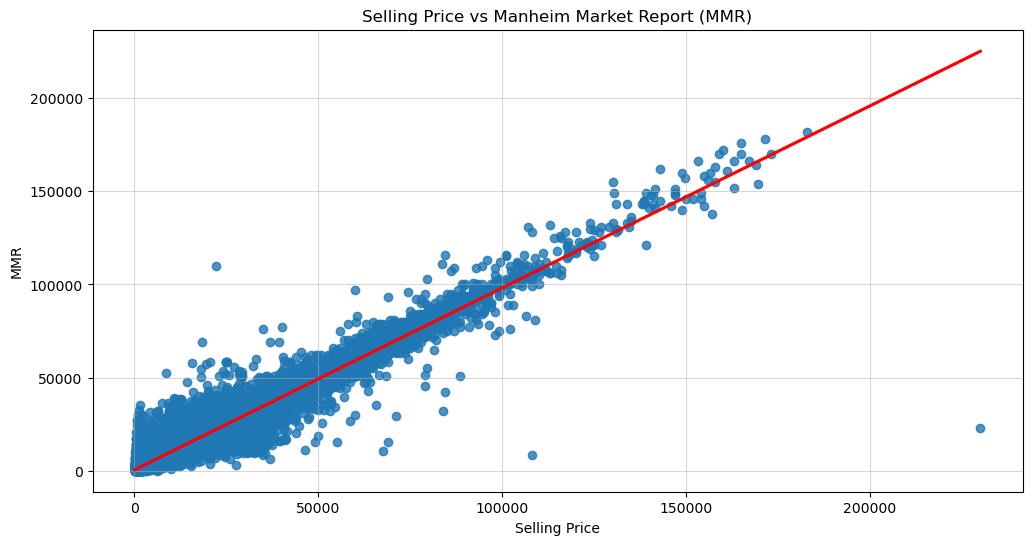

In [55]:
plt.figure(figsize=(12,6))
plt.title('Selling Price vs Manheim Market Report (MMR)')
sns.regplot(x=df['sellingprice'], y=df['mmr'], marker='o', line_kws={'color': 'red'})
plt.xlabel('Selling Price')
plt.ylabel('MMR')
plt.grid(alpha=0.5)
plt.show();

The graph confirms a strong linear relationship between the selling price and the estimated market value (by Manheim Market Report (MMR)). This suggests that the selling price of a car is almost always close to its market value, according to Manheim Market Report (MMR). Rare deviations might indicate that the selling price of the vehicle was altered for some other reasons (e.g., the rarity of the car, additional features, condition, or individual factors).

Let's calculate the Pearson correlation coefficient between "sellingprice" and "mmr":

In [58]:
np.corrcoef(df['sellingprice'],df['mmr'])

array([[1.        , 0.98365924],
       [0.98365924, 1.        ]])

A high correlation (0.98) confirms that the car sale prices are close to their market value, indicating a high accuracy of the Manheim Market Report (MMR) estimation for most cars in the dataset.

#### **3.5 How does the car's color influence its selling price and the number of units sold?**

In [61]:
average_price_by_color = df.groupby('color')['sellingprice'].mean().round(2).reset_index()

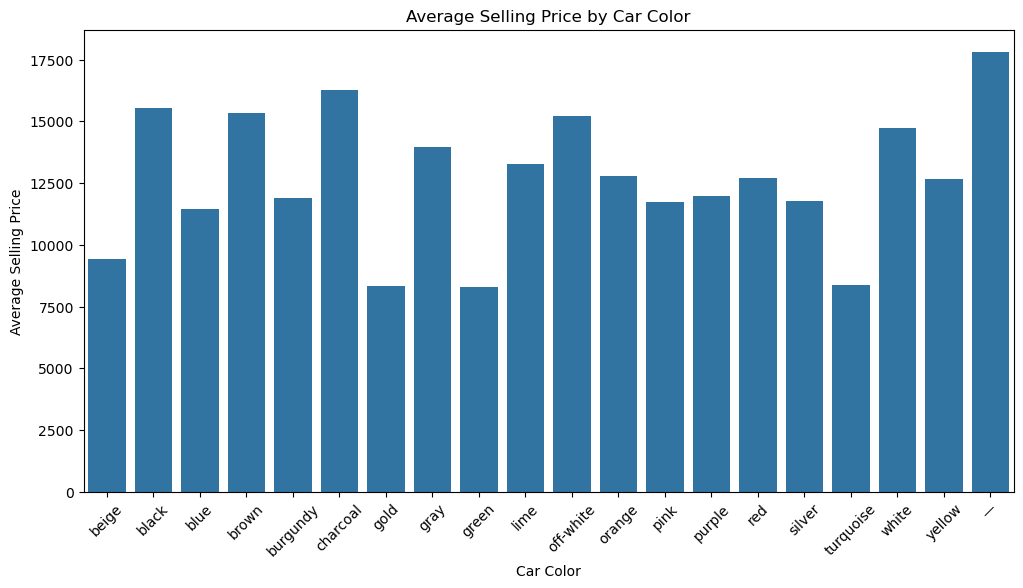

In [62]:
plt.figure(figsize=(12, 6))
sns.barplot(x='color', y='sellingprice', data=average_price_by_color)
plt.xticks(rotation=45)
plt.title('Average Selling Price by Car Color')
plt.xlabel('Car Color')
plt.ylabel('Average Selling Price')
plt.show()

In [63]:
color_counts = df['color'].value_counts().reset_index()

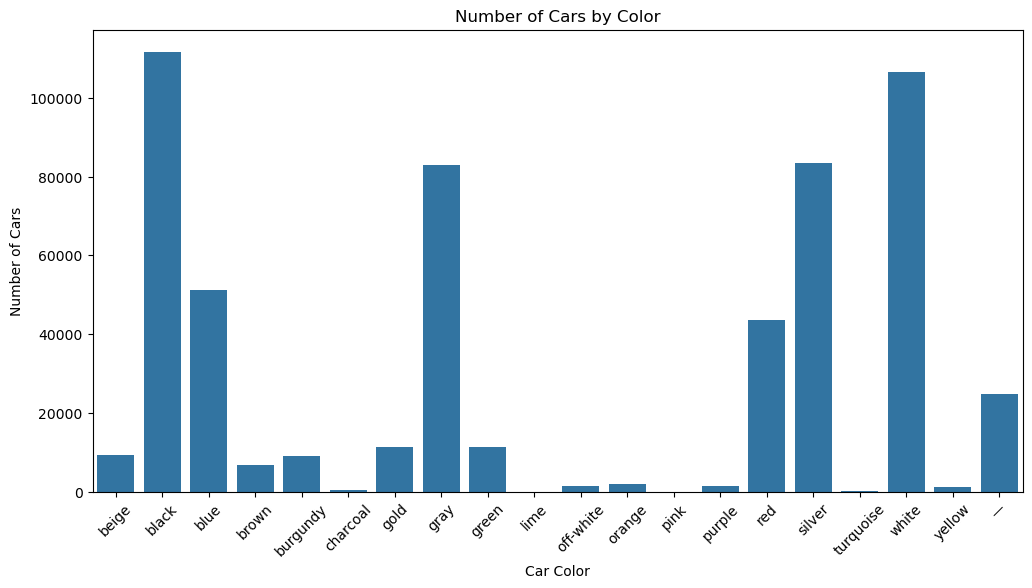

In [64]:
plt.figure(figsize=(12,6))
sns.barplot(x='color', y='count', data=color_counts)
plt.title('Number of Cars by Color')
plt.xlabel('Car Color')
plt.ylabel('Number of Cars')
plt.xticks(rotation=45)
plt.show();

As we can see:
- all cars (with a specified color in the dataset) were sold with an average price not lower than 7500;
- in terms of the number of cars sold, vehicles in the following colors lead: black, gray, silver, and white.

#### **3.6 How does seasonality affect the selling price of a car and the number of sales?**

To start, let's plot a line chart showing the number of sales over the period.

In [68]:
sales_by_day = df.groupby('saledate').size().reset_index(name='sales_count')

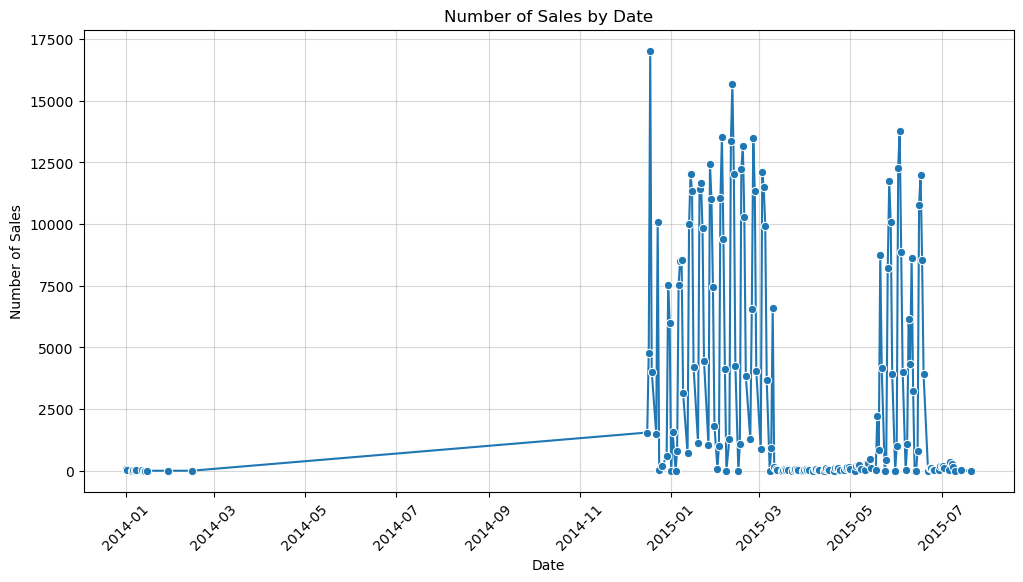

In [69]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='saledate', y='sales_count', data=sales_by_day, marker='o')
plt.title('Number of Sales by Date')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.show()

Next, let's plot the graphs showing the impact of seasonality on the number of sales and the average selling price.

In [71]:
df['month'] = df['saledate'].dt.month 

In [72]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)

In [73]:
seasonal_analysis = df.groupby('season').agg(
    avg_price=('sellingprice', 'mean'),
    sales_count=('sellingprice', 'count')
).reset_index()

seasonal_analysis

,season,avg_price,sales_count
0,Spring,13866.845188,100173
1,Summer,15033.54484,101237
2,Winter,13130.132008,357184


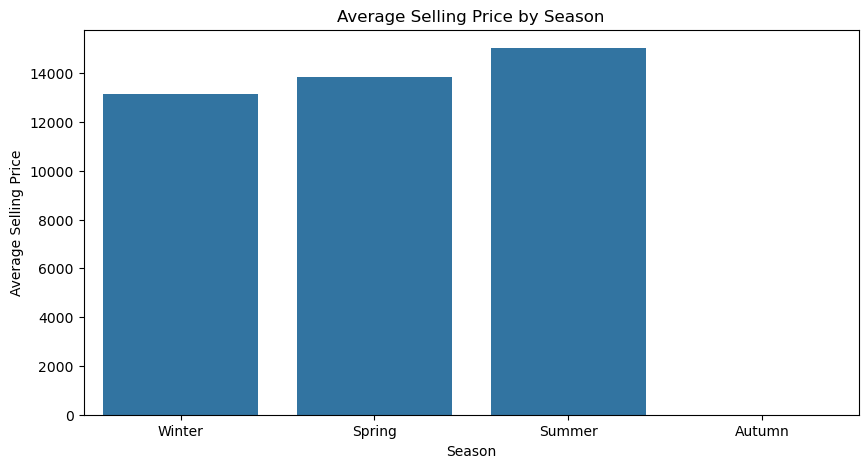

In [74]:
plt.figure(figsize=(10, 5))
sns.barplot(x='season', y='avg_price', data=seasonal_analysis, order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Average Selling Price by Season')
plt.xlabel('Season')
plt.ylabel('Average Selling Price')
plt.show()

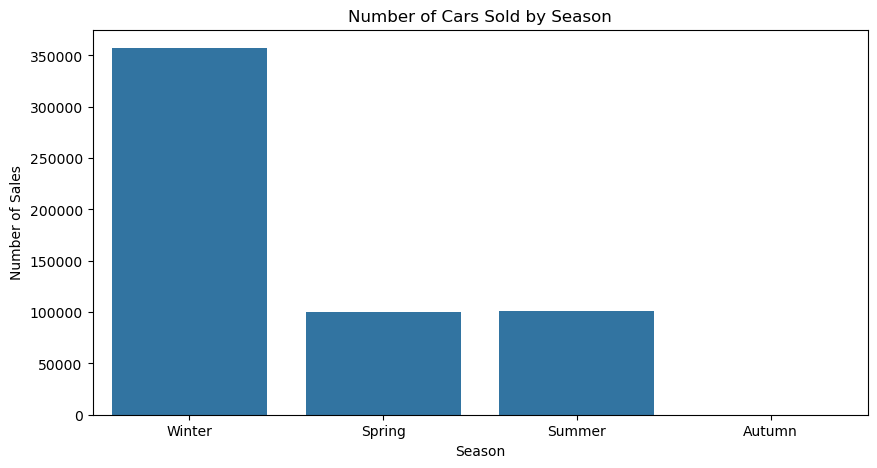

In [75]:
plt.figure(figsize=(10, 5))
sns.barplot(x='season', y='sales_count', data=seasonal_analysis, order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Number of Cars Sold by Season')
plt.xlabel('Season')
plt.ylabel('Number of Sales')
plt.show()

As we can see, the highest average price is observed in summer, while the lowest is in winter. In terms of the number of sales, winter leads.

#### **3.7 Which top 10 car models depreciate the fastest?**

In [78]:
df['price_diff'] = df['sellingprice'] - df['mmr']
price_diff_by_model = df.groupby('model')['price_diff'].mean().reset_index()
price_diff_by_model = price_diff_by_model.sort_values(by='price_diff', ascending=False)
top_models_price_drop = price_diff_by_model.head(10)

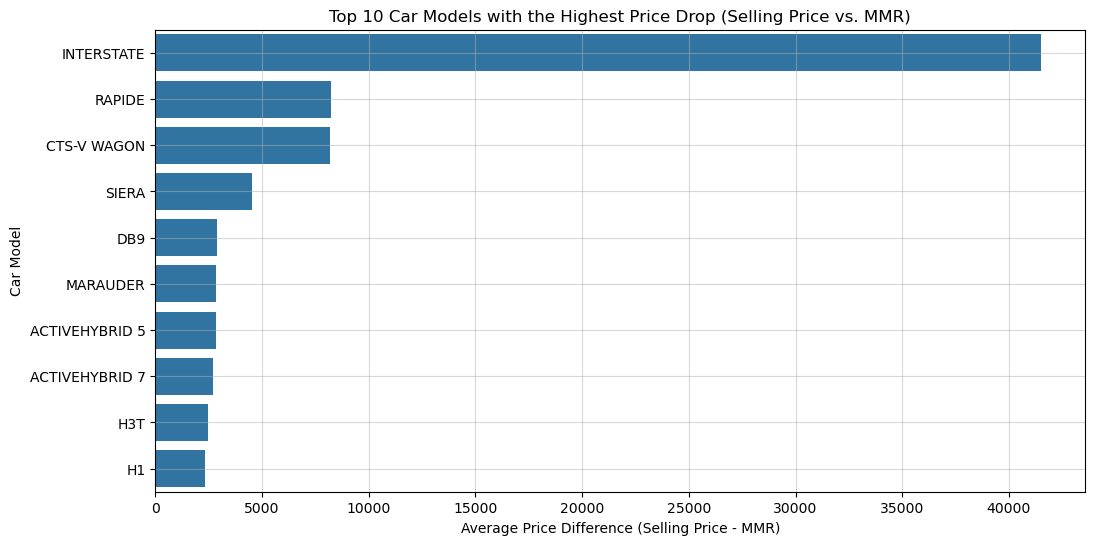

In [79]:
plt.figure(figsize=(12, 6))
sns.barplot(x='price_diff', y='model', data=top_models_price_drop)
plt.title('Top 10 Car Models with the Highest Price Drop (Selling Price vs. MMR)')
plt.xlabel('Average Price Difference (Selling Price - MMR)')
plt.ylabel('Car Model')
plt.grid(alpha=0.5)
plt.show();

#### **3.8 Does the state of vehicle registration affect its sale price and the number of sales?**

Let's create a pivot table showing the average selling price and the number of sales by state.

In [82]:
state_price_pivot = df.pivot_table(values='sellingprice', index='state', aggfunc=['mean', 'count']).reset_index()
state_price_pivot.columns = ['State', 'Average Selling Price', 'Number of Sales']
state_price_pivot[['Average Selling Price']] = state_price_pivot[['Average Selling Price']].round(2)
state_price_pivot.sort_values(by='Average Selling Price', ascending=False) 

,State,Average Selling Price,Number of Sales
26,on,17812.62,3442
32,tn,17001.7,20887
28,pa,15973.04,53897
4,co,15876.31,7773
22,nv,15095.67,12675
13,mi,14884.75,15509
8,il,14790.95,23477
3,ca,14501.44,73088
15,mo,14466.19,16013
24,oh,14386.32,21543


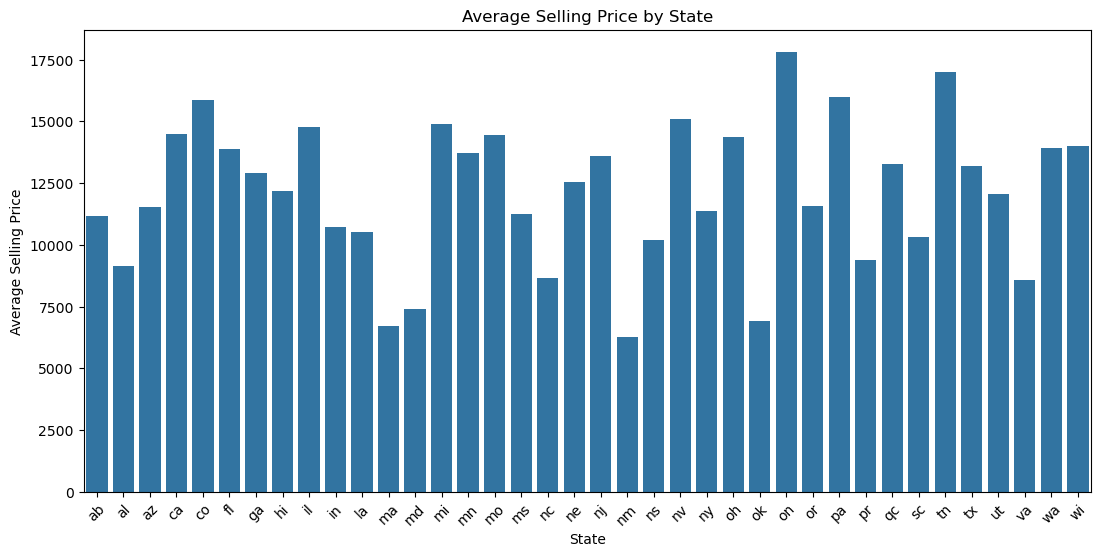

In [83]:
plt.figure(figsize=(13, 6))
sns.barplot(x='State', y='Average Selling Price', data=state_price_pivot)
plt.xticks(rotation=45)
plt.title('Average Selling Price by State')
plt.xlabel('State')
plt.ylabel('Average Selling Price')
plt.show();

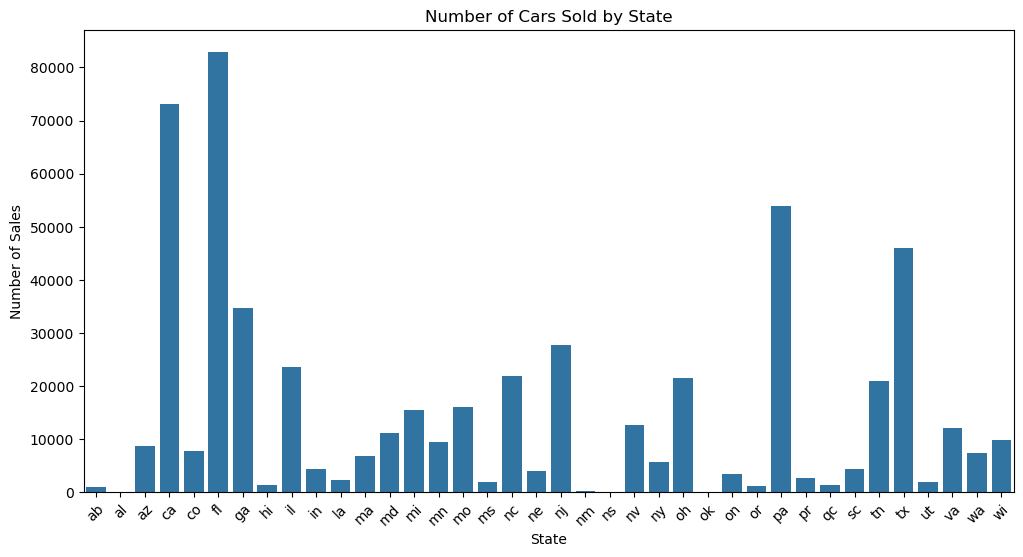

In [84]:
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Number of Sales', data=state_price_pivot)
plt.xticks(rotation=45)
plt.title('Number of Cars Sold by State')
plt.xlabel('State')
plt.ylabel('Number of Sales')
plt.show()

As we can see, states with a high number of sales often have lower vehicle prices, which may indicate high demand for more affordable models.
States with a high average price may specialize in selling more expensive vehicles, but the number of sales in these states is relatively low.

#### **3.9 How does the condition of a vehicle affect its sale price?**

To begin with, let's take a look at the scale of values in the 'condition' column:

In [88]:
df.groupby('condition')['sellingprice'].mean()

condition
1.000000      3910.261497
2.000000      5689.756123
3.000000     12272.824613
4.000000     17722.152919
5.000000     24705.355591
11.000000     4504.482759
12.000000     3820.789474
13.000000     3554.878049
14.000000     3323.880597
15.000000     3913.541667
16.000000     4386.235955
17.000000     4074.897119
18.000000     4584.055728
19.000000     5082.002531
21.000000     7331.394542
22.000000     7616.581311
23.000000     8062.063874
24.000000     8356.721763
25.000000     8839.977387
26.000000     9174.055663
27.000000     9643.028196
28.000000    10197.399718
29.000000    10756.653017
30.672365      6517.10062
31.000000    11652.596725
32.000000     11868.65385
33.000000    12218.919672
34.000000    12724.654346
35.000000    13368.626911
36.000000    14089.676635
37.000000    14858.333693
38.000000    15443.941456
39.000000    15982.995732
41.000000     17328.86247
42.000000    17931.615805
43.000000    18609.404565
44.000000    19218.621751
45.000000    20008.677044
46

Let's divide the condition into 5 categories and plot the relationship between the condition and the selling price:

In [90]:
def condition_group(x):
    if x <= 10:
        return 'Poor'
    elif 10 < x <= 20:
        return 'Fair'
    elif 20 < x <= 30:
        return 'Good'
    elif 30 < x <= 40:
        return 'Very Good'
    else:
        return 'Excellent'

df['condition_group'] = df['condition'].apply(condition_group)
average_price_by_condition = df.groupby('condition_group')['sellingprice'].mean()

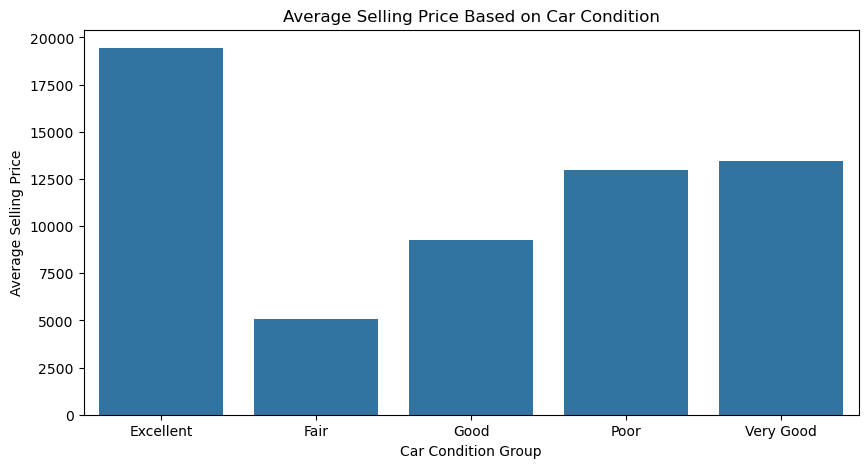

In [91]:
plt.figure(figsize=(10, 5))
sns.barplot(x=average_price_by_condition.index, y=average_price_by_condition.values)
plt.title('Average Selling Price Based on Car Condition')
plt.xlabel('Car Condition Group')
plt.ylabel('Average Selling Price')
plt.xticks()
plt.show()

As we can see, the average sale price of cars in Excellent condition is higher, which seems logical. What stands out is the higher average sale price in the Poor condition group compared to the Good and Fair groups. This may likely be due to special characteristics of these cars, such as collectible vehicles, which might be in poor condition but are still highly valued.

#### **3.10 Is there a relationship between a car's odometer reading and its year of manufacture?**

Let's create a scatter plot to show the relationship between a car's odometer reading and its year of manufacture:

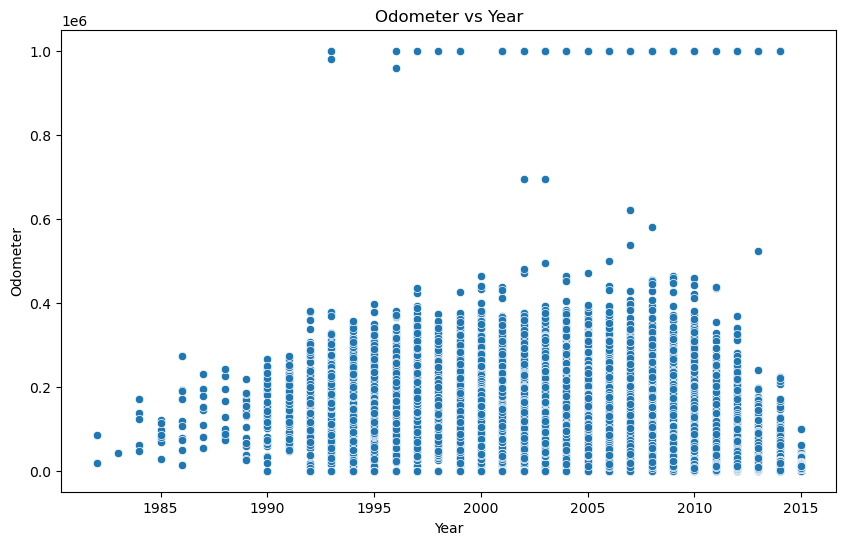

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='odometer', data=df)
plt.title('Odometer vs Year')
plt.xlabel('Year')
plt.ylabel('Odometer')
plt.show()

Let's calculate the Pearson correlation coefficient between "odometer" and "year":

In [97]:
np.corrcoef(df['odometer'], df['year'])

array([[ 1.       , -0.7723848],
       [-0.7723848,  1.       ]])

The Pearson correlation coefficient between the odometer reading and the year of manufacture is -0.772. This indicates a strong negative correlation between the two variables.
In other words, the newer the car, the odometer reading it usually has, since it hasn't been driven as much. Meanwhile, older cars tend to have higher in the odometer reading due to more years of use.
Except for a some outliers, we can see a similar trend on the scatter plot.

#### **3.11 In which states are cars with the highest odometer readings sold?**

To answer this question, let's create a bar plot showing the average odometer reading by state.

In [101]:
avg_odometer_by_state = df.groupby('state')['odometer'].mean()

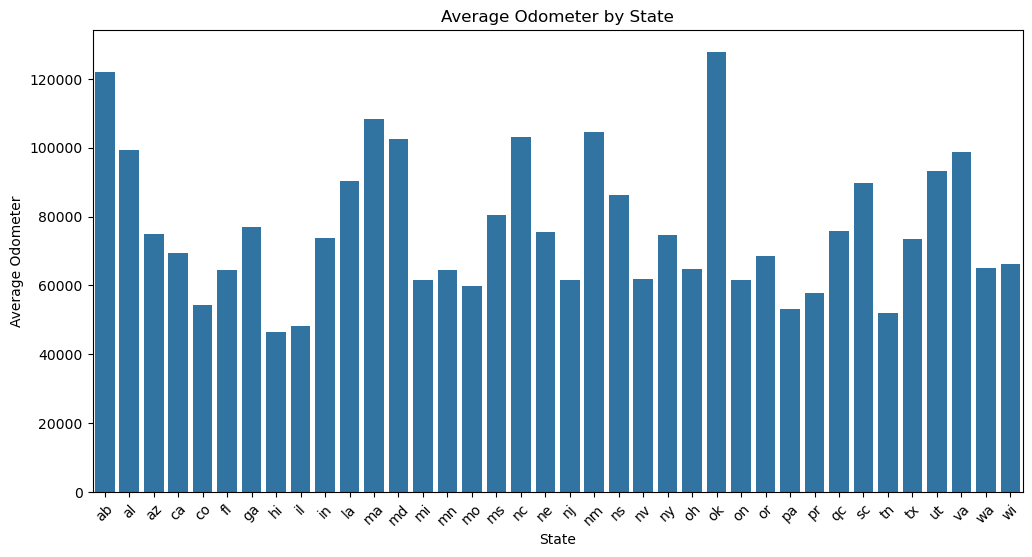

In [102]:
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_odometer_by_state.index, y=avg_odometer_by_state.values)

plt.title('Average Odometer by State')
plt.xlabel('State')
plt.ylabel('Average Odometer')
plt.xticks(rotation=45)
plt.show();

### **4. Saving the dataset to a file**

In [104]:
df.to_excel('car_prices_cleaned_data.xlsx', index=False)
print("DataFrame successfully exported.")

DataFrame successfully exported.


### **5. Key Insights**

Car sales data analysis has shown that several key factors influence a car's price. First and foremost, it's the year of manufacture and odometer readings: the newer the car and the lower its mileage, the higher its price. Transmission type and car brand are also important factors — cars with automatic transmissions generally cost more. The condition of the car also plays a role, but rare models can maintain a high price even in poor condition. Seasonal changes and regional differences, which also affect prices and sales volumes, should not be forgotten. This analysis can be a useful tool for car dealerships and private sellers, helping to optimize pricing, predict demand, and better understand customer needs.